In [1]:
import os
import scipy.io
import mne
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.signal import stft
import warnings

mne.set_log_level("ERROR") 
warnings.filterwarnings('ignore')

In [2]:
groups = {
    "Depressed": [566, 571, 594, 597, 602],
    "Control": [512, 532, 560, 574, 577]
}

ch_names = [
    'FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
    'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
    'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ', 'O2'
]

sfreq = 500 

stimulus_data = {}
reward_data = {}
punishment_data = {}
response_data = {}

for group, subjects in groups.items():

    stimulus_data[group] = {}
    reward_data[group] = {}
    punishment_data[group] = {}
    response_data[group] = {}

    for subj in subjects:
        subj_dir = os.path.join(group, str(subj))
        
        if not os.path.exists(subj_dir):
            print(f"  Directory not found for subject: {subj}")
            continue

        conditions = ["Stimulus", "Reward", "Punishment", "Response"]

        for condition in conditions:
            file_name = f"{condition}_{subj}.mat"
            file_path = os.path.join(subj_dir, file_name)

            if os.path.exists(file_path):
                mat_data = scipy.io.loadmat(file_path)

                data = mat_data.get(condition) 
                if data is None:
                    print(f"      '{condition}' key not found in {file_name}. Skipping...")
                    continue

                if data.ndim != 3:
                    print(f"    Data shape error for {file_name}. Expected 3D array, got {data.shape}. Skipping...")
                    continue

                n_channels, n_timepoints, n_trials = data.shape

                data = data.transpose((2, 0, 1))

                events = np.array([[i, 0, 1] for i in range(n_trials)])

                info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")

                epochs = mne.EpochsArray(data, info, events)

                if condition == "Stimulus":
                    stimulus_data[group][subj] = epochs
                elif condition == "Reward":
                    reward_data[group][subj] = epochs
                elif condition == "Punishment":
                    punishment_data[group][subj] = epochs
                elif condition == "Response":
                    response_data[group][subj] = epochs
            else:
                print(f"    File not found: {file_path}")


In [3]:
channels_to_keep = [
    "FPZ", "F7", "F3", "FZ", "F4", "F8", 
    "C3", "CZ", "C4", "T7", "T8", 
    "P7", "P3", "PZ", "P4", "P8", 
    "OZ"
]

def filter_channels(data_dict):
    for group in data_dict:
        for subj in data_dict[group]:
            epochs = data_dict[group][subj]
            epochs.pick_channels(channels_to_keep)

filter_channels(stimulus_data)
filter_channels(reward_data)
filter_channels(punishment_data)
filter_channels(response_data)


In [4]:
def normalize_with_zscore(data_dict):
    for group in data_dict:
        for subj in data_dict[group]:
            epochs = data_dict[group][subj] 
            data = epochs.get_data()

            normalized_data = zscore(data, axis=-1)

            epochs._data = normalized_data

normalize_with_zscore(stimulus_data)
normalize_with_zscore(reward_data)
normalize_with_zscore(punishment_data)
normalize_with_zscore(response_data)


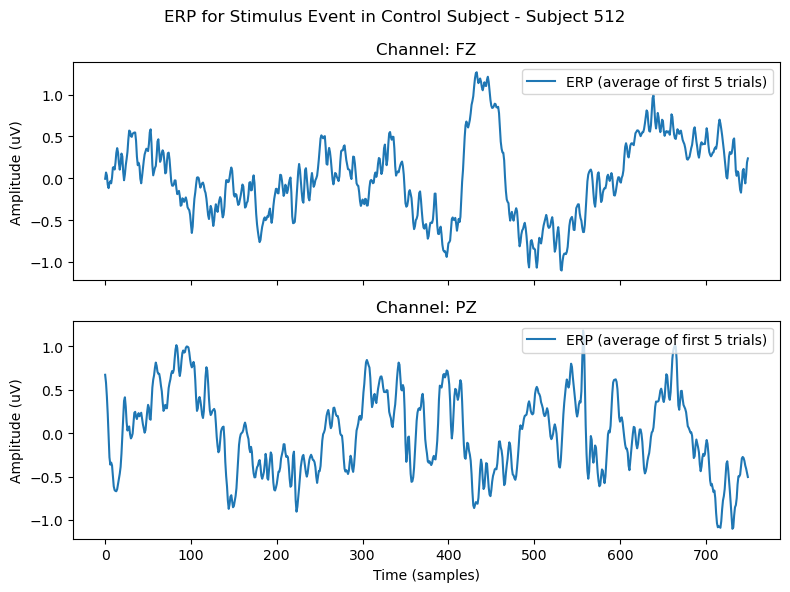

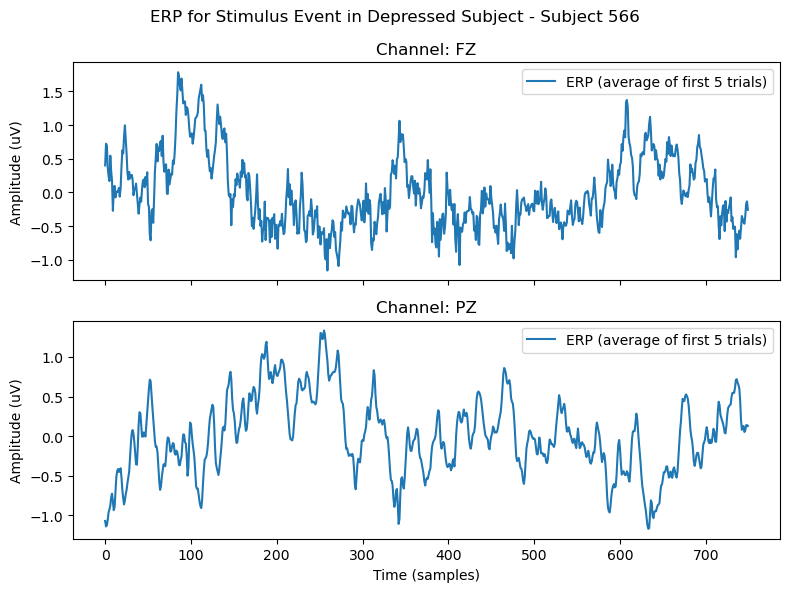

In [5]:
control_subject = 512  
depressed_subject = 566  

channels_to_plot = ["FZ", "PZ"]
n_trials = 5  

def plot_erp(data_dict, subject_id, n_trials, group, title):
    epochs = data_dict[group][subject_id]  
    data = epochs.get_data()  

    channel_indices = [epochs.ch_names.index(ch) for ch in channels_to_plot]

    fig, axes = plt.subplots(len(channel_indices), 1, figsize=(8, 6), sharex=True)
    fig.suptitle(f"{title} - Subject {subject_id}")
    
    for i, ch_idx in enumerate(channel_indices):
        axes[i].set_title(f"Channel: {channels_to_plot[i]}")

        erp_data = np.mean(data[:n_trials, ch_idx, :], axis=0)
        axes[i].plot(erp_data, label = f"ERP (average of first {n_trials} trials)")
        
        axes[i].legend(loc="upper right")
        axes[i].set_ylabel("Amplitude (uV)")

    axes[-1].set_xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()

plot_erp(stimulus_data, control_subject, n_trials, "Control", "ERP for Stimulus Event in Control Subject")

plot_erp(stimulus_data, depressed_subject, n_trials, "Depressed", "ERP for Stimulus Event in Depressed Subject")


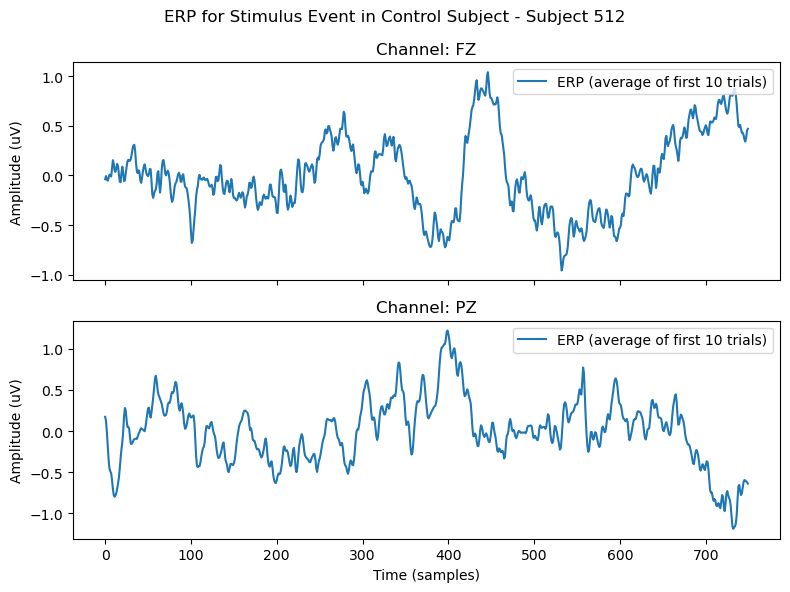

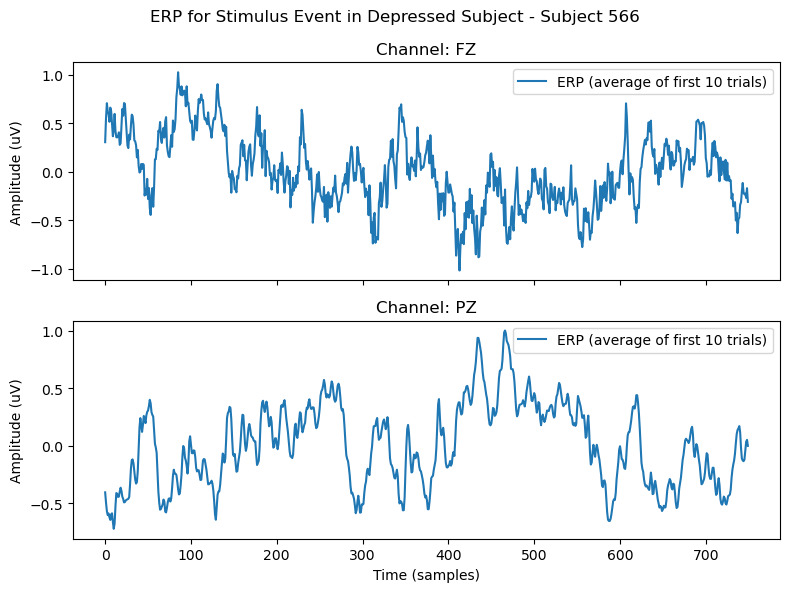

In [6]:
n_trials = 10

plot_erp(stimulus_data, control_subject, n_trials, "Control", "ERP for Stimulus Event in Control Subject")

plot_erp(stimulus_data, depressed_subject, n_trials, "Depressed", "ERP for Stimulus Event in Depressed Subject")

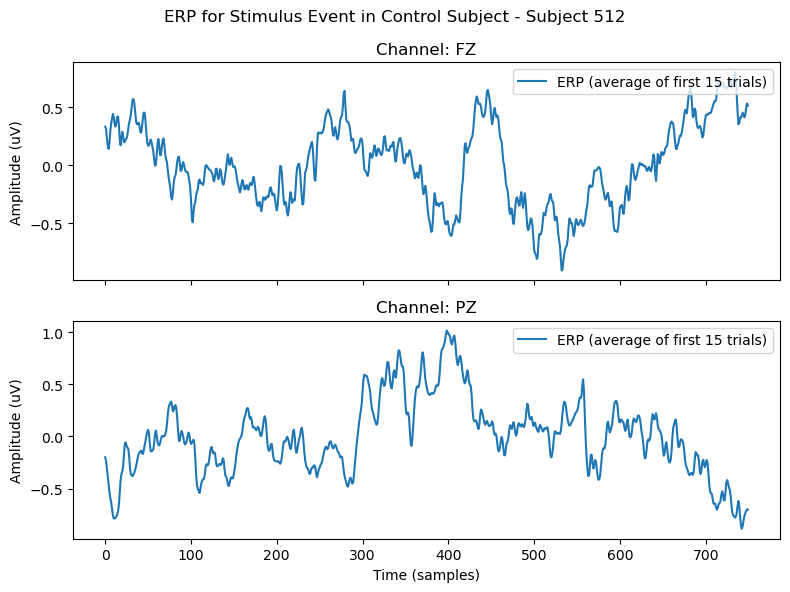

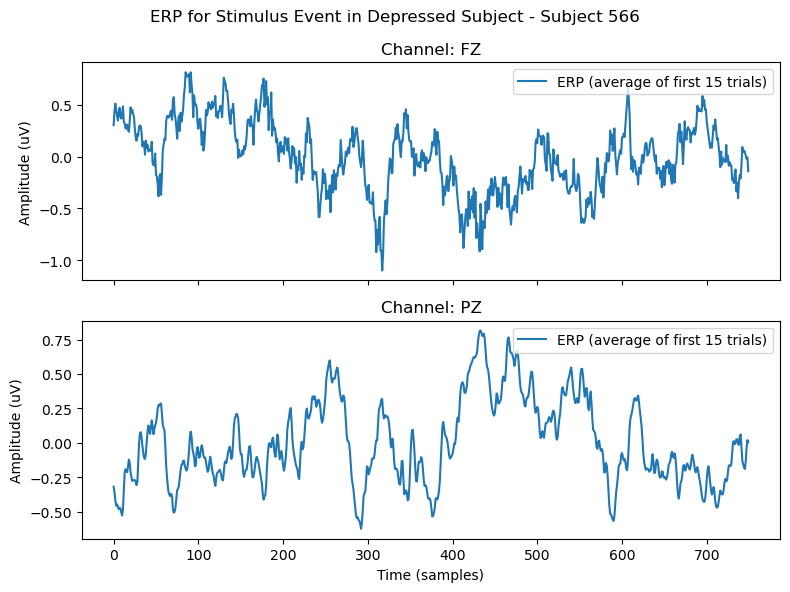

In [7]:
n_trials = 15

plot_erp(stimulus_data, control_subject, n_trials, "Control", "ERP for Stimulus Event in Control Subject")

plot_erp(stimulus_data, depressed_subject, n_trials, "Depressed", "ERP for Stimulus Event in Depressed Subject")

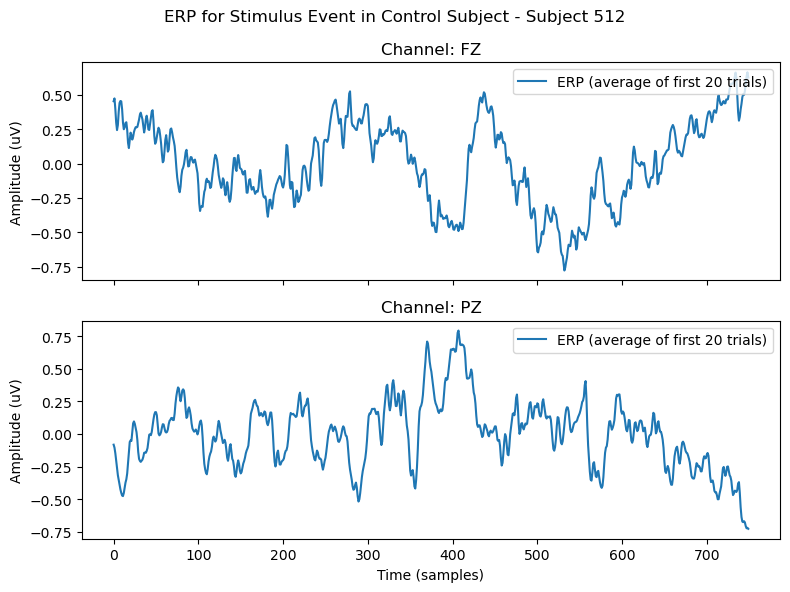

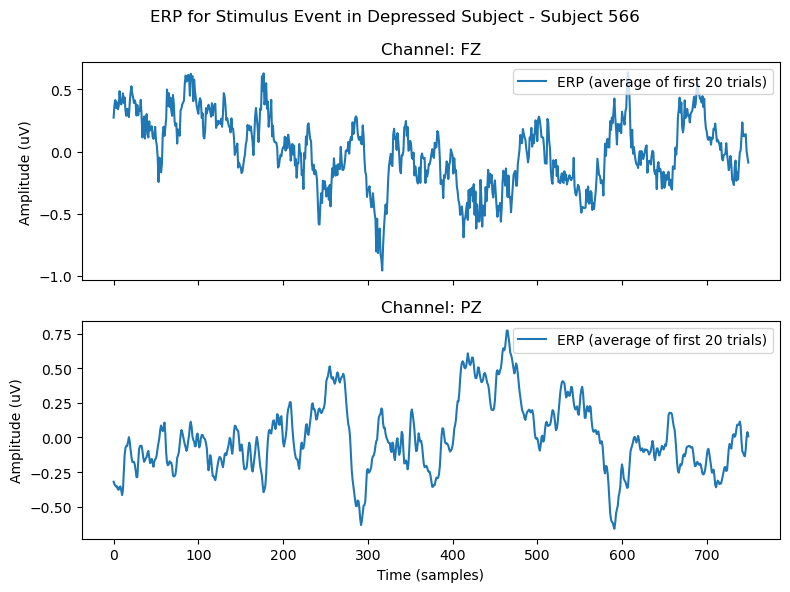

In [8]:
n_trials = 20

plot_erp(stimulus_data, control_subject, n_trials, "Control", "ERP for Stimulus Event in Control Subject")

plot_erp(stimulus_data, depressed_subject, n_trials, "Depressed", "ERP for Stimulus Event in Depressed Subject")

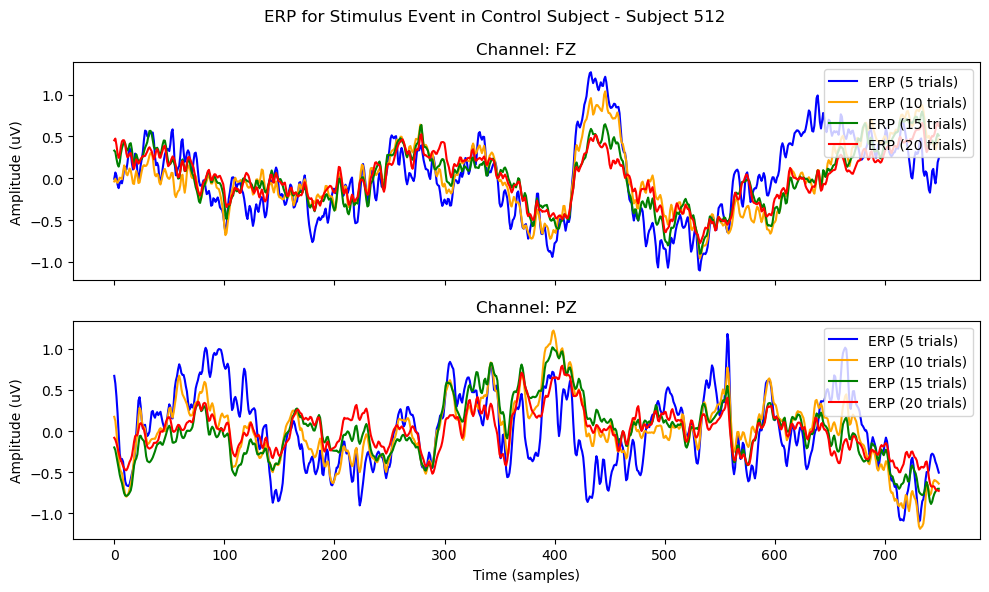

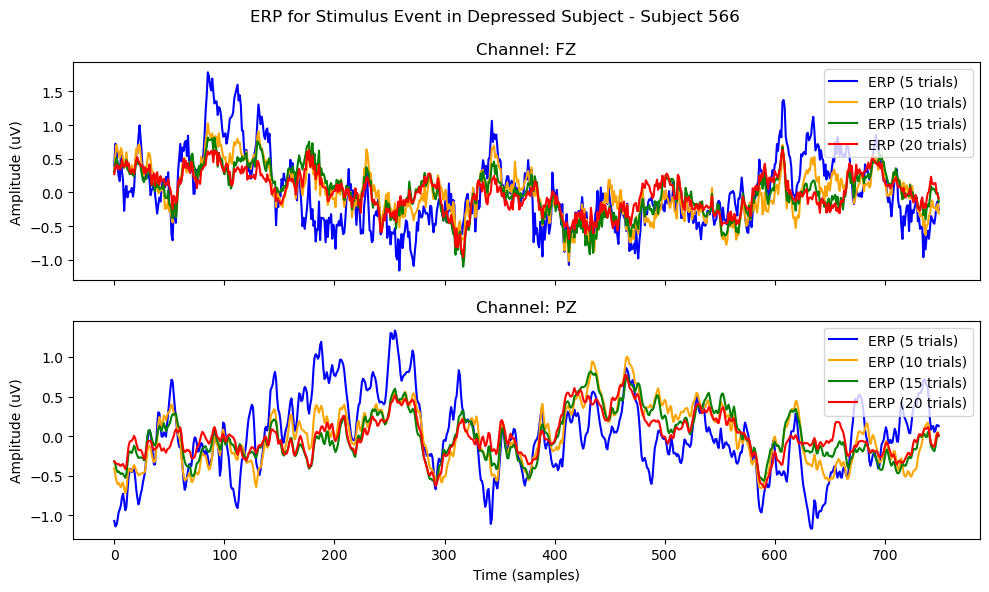

In [9]:
control_subject = 512  
depressed_subject = 566  

channels_to_plot = ["FZ", "PZ"]
trial_counts = [5, 10, 15, 20]  
colors = ["blue", "orange", "green", "red"] 

def plot_erp_multiple_trials(data_dict, subject_id, group, title):
    epochs = data_dict[group][subject_id]
    data = epochs.get_data()  

    channel_indices = [epochs.ch_names.index(ch) for ch in channels_to_plot]

    fig, axes = plt.subplots(len(channel_indices), 1, figsize=(10, 6), sharex=True)
    fig.suptitle(f"{title} - Subject {subject_id}")
    
    for i, ch_idx in enumerate(channel_indices):
        axes[i].set_title(f"Channel: {channels_to_plot[i]}")

        for n_trials, color in zip(trial_counts, colors):
            if n_trials <= data.shape[0]:  
                erp_data = np.mean(data[:n_trials, ch_idx, :], axis=0)  
                axes[i].plot(erp_data, label=f"ERP ({n_trials} trials)", color=color)
        
        axes[i].legend(loc="upper right")
        axes[i].set_ylabel("Amplitude (uV)")

    axes[-1].set_xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()

plot_erp_multiple_trials(stimulus_data, control_subject, "Control", "ERP for Stimulus Event in Control Subject")

plot_erp_multiple_trials(stimulus_data, depressed_subject, "Depressed", "ERP for Stimulus Event in Depressed Subject")


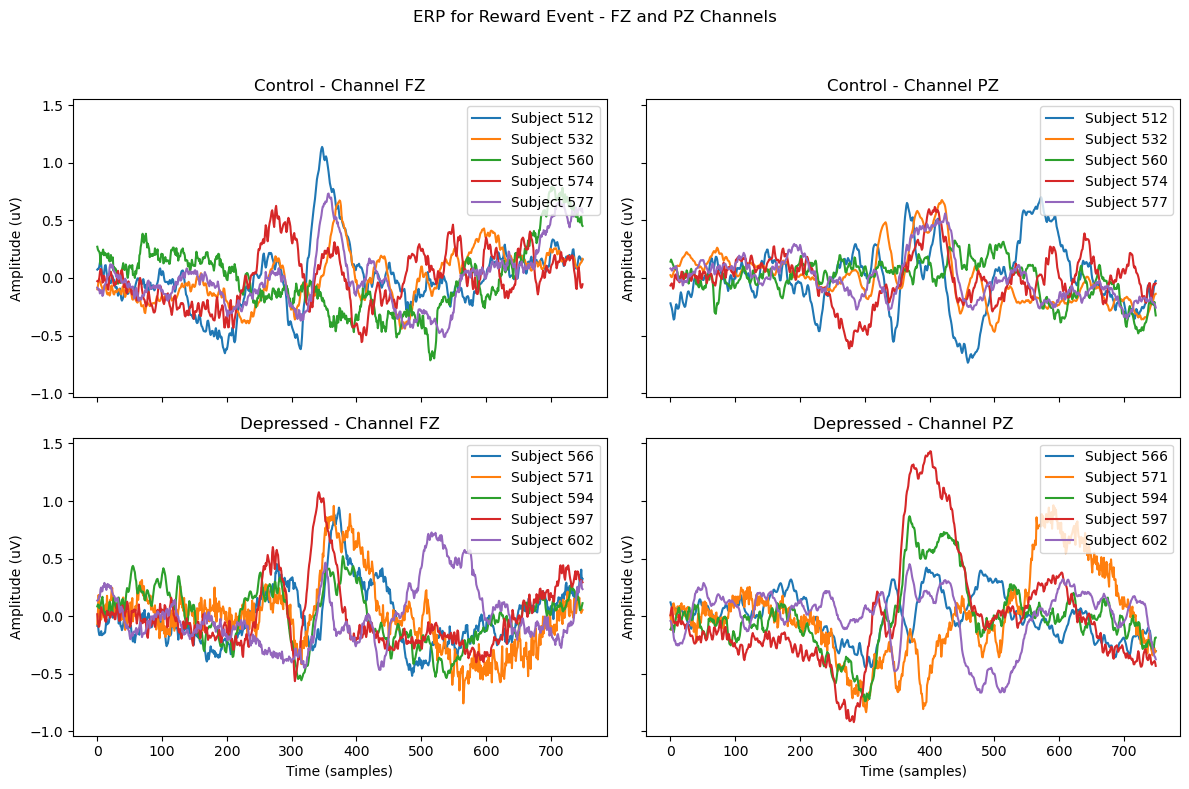

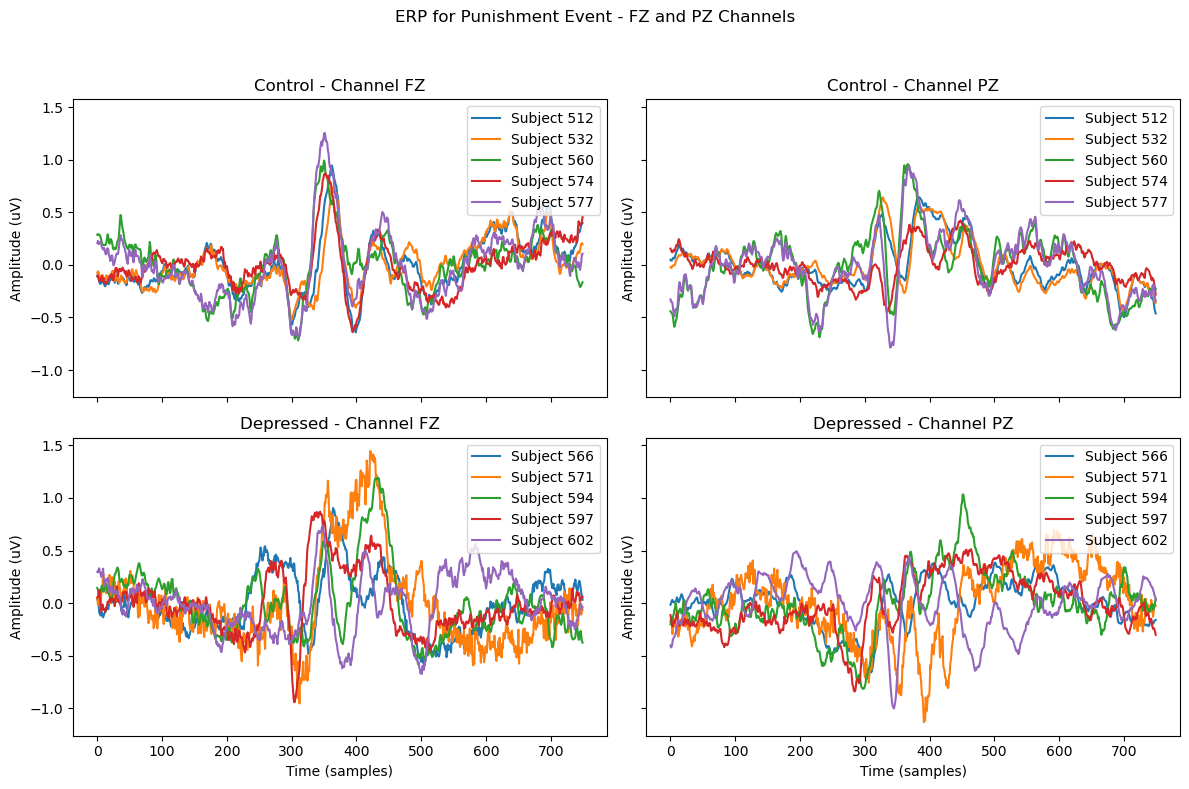

In [10]:
channels_to_plot = ["FZ", "PZ"]

def compute_and_plot_erp(data_dict, condition_name):
    erp_results = {"Control": {}, "Depressed": {}}

    for group, subjects in data_dict.items():
        for subj in subjects:
            epochs = data_dict[group][subj]  
            data = epochs.get_data()  

            erp_data = np.mean(data, axis=0)  

            erp_results[group][subj] = {
                ch: erp_data[epochs.ch_names.index(ch), :] for ch in channels_to_plot
            }

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    fig.suptitle(f"ERP for {condition_name} Event - FZ and PZ Channels")

    for i, (group, group_data) in enumerate(erp_results.items()):
        for j, ch in enumerate(channels_to_plot):
            ax = axes[i, j]
            ax.set_title(f"{group} - Channel {ch}")
            for subj, subj_data in group_data.items():
                ax.plot(subj_data[ch], label=f"Subject {subj}", alpha=1)

            ax.set_ylabel("Amplitude (uV)")
            if i == 1:
                ax.set_xlabel("Time (samples)")
            ax.legend(loc="upper right")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

compute_and_plot_erp(reward_data, "Reward")

compute_and_plot_erp(punishment_data, "Punishment")


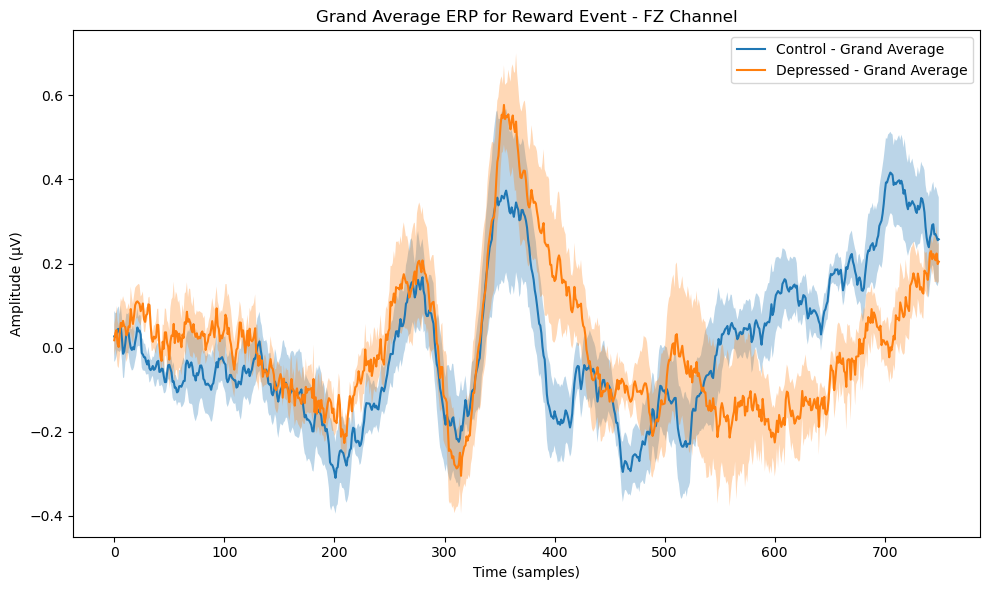

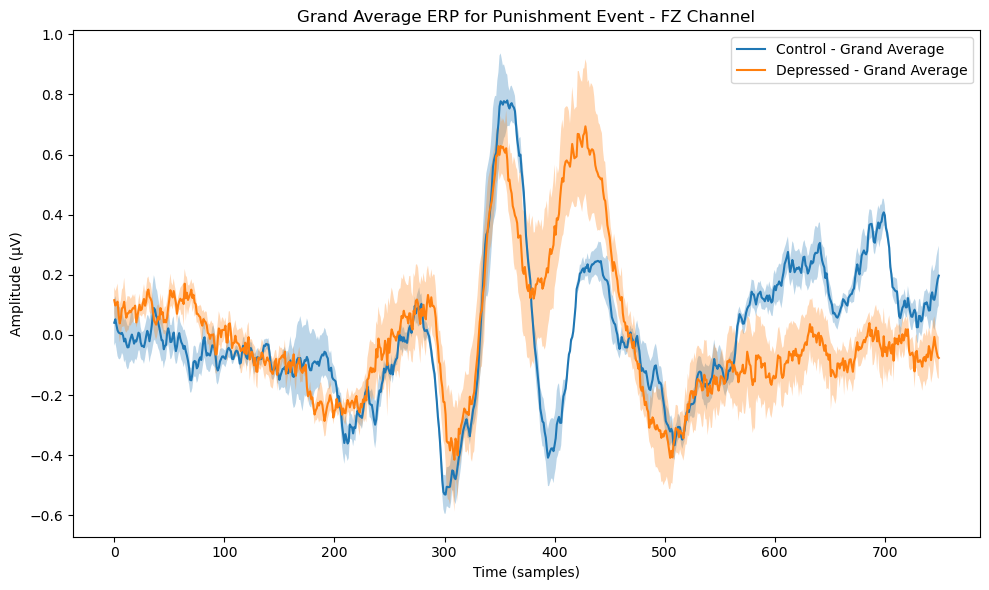

In [11]:
channels_to_plot = ["FZ"]

def compute_erp(data_dict, condition_name):
    erp_results = {"Control": {}, "Depressed": {}}

    for group, subjects in data_dict.items():
        for subj in subjects:
            epochs = data_dict[group][subj]  
            data = epochs.get_data()  

            erp_data = np.mean(data, axis=0)  

            erp_results[group][subj] = {
                ch: erp_data[epochs.ch_names.index(ch), :] for ch in channels_to_plot
            }

    return erp_results

def compute_grand_average_and_se(erp_results):
    grand_averages = {"Control": {}, "Depressed": {}}
    standard_errors = {"Control": {}, "Depressed": {}}

    for group, group_data in erp_results.items():
        for ch in channels_to_plot:
            all_subjects_data = [subj_data[ch] for subj_data in group_data.values()]
            
            grand_avg = np.mean(all_subjects_data, axis=0)
            grand_averages[group][ch] = grand_avg

            n = len(all_subjects_data)
            std_error = np.std(all_subjects_data, axis=0) / np.sqrt(n)
            standard_errors[group][ch] = std_error

    return grand_averages, standard_errors

def plot_grand_average_with_se(grand_averages, standard_errors, condition_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    for group, group_data in grand_averages.items():
        for ch in channels_to_plot:
            grand_avg = group_data[ch]
            se = standard_errors[group][ch]
            
            ax.plot(grand_avg, label=f"{group} - Grand Average", alpha=1.0)

            ax.fill_between(np.arange(len(grand_avg)), 
                            grand_avg - se, 
                            grand_avg + se, 
                            alpha=0.3)

    ax.set_title(f"Grand Average ERP for {condition_name} Event - FZ Channel")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude (µV)")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

reward_erp_results = compute_erp(reward_data, "Reward")
punishment_erp_results = compute_erp(punishment_data, "Punishment")

reward_grand_avg, reward_se = compute_grand_average_and_se(reward_erp_results)
punishment_grand_avg, punishment_se = compute_grand_average_and_se(punishment_erp_results)

plot_grand_average_with_se(reward_grand_avg, reward_se, "Reward")
plot_grand_average_with_se(punishment_grand_avg, punishment_se, "Punishment")


## Time-Frequency Analysis

In [12]:
groups = {
    "Depressed": [566, 571, 594, 597, 602],
    "Control": [512, 532, 560, 574, 577]
}

ch_names = [
    'FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
    'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
    'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ', 'O2'
]

sfreq = 500 

stimulus_data = {}
reward_data = {}
punishment_data = {}
response_data = {}

for group, subjects in groups.items():

    stimulus_data[group] = {}
    reward_data[group] = {}
    punishment_data[group] = {}
    response_data[group] = {}

    for subj in subjects:
        subj_dir = os.path.join(group, str(subj))
        
        if not os.path.exists(subj_dir):
            print(f"  Directory not found for subject: {subj}")
            continue

        conditions = ["Stimulus", "Reward", "Punishment", "Response"]

        for condition in conditions:
            file_name = f"{condition}_{subj}.mat"
            file_path = os.path.join(subj_dir, file_name)

            if os.path.exists(file_path):
                mat_data = scipy.io.loadmat(file_path)

                data = mat_data.get(condition)  
                if data is None:
                    print(f"      '{condition}' key not found in {file_name}. Skipping...")
                    continue

                if data.ndim != 3:
                    print(f"    Data shape error for {file_name}. Expected 3D array, got {data.shape}. Skipping...")
                    continue

                n_channels, n_timepoints, n_trials = data.shape

                data = data.transpose((2, 0, 1))

                events = np.array([[i, 0, 1] for i in range(n_trials)])

                info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")

                epochs = mne.EpochsArray(data, info, events)

                if condition == "Stimulus":
                    stimulus_data[group][subj] = epochs
                elif condition == "Reward":
                    reward_data[group][subj] = epochs
                elif condition == "Punishment":
                    punishment_data[group][subj] = epochs
                elif condition == "Response":
                    response_data[group][subj] = epochs
            else:
                print(f"    File not found: {file_path}")


In [13]:
def normalize_with_zscore(data_dict):
    for group in data_dict:
        for subj in data_dict[group]:
            epochs = data_dict[group][subj] 
            data = epochs.get_data()

            normalized_data = zscore(data, axis=-1)

            epochs._data = normalized_data

normalize_with_zscore(stimulus_data)
normalize_with_zscore(reward_data)
normalize_with_zscore(punishment_data)
normalize_with_zscore(response_data)


In [14]:
frequency_bands = {
    "delta": (3, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

def compute_stft_power(data_dict, channel="FZ", sfreq=500, n_trials=15):
    power_results = {"Control": {}, "Depressed": {}}
    for group, subjects in data_dict.items():
        for subj, epochs in subjects.items():
            channel_idx = epochs.ch_names.index(channel)
            data = epochs.get_data()[:n_trials, channel_idx, :]  

            f, t, Zxx = stft(data, fs=sfreq, nperseg=300, noverlap=100, axis=-1) 
            power = np.abs(Zxx) ** 2  

            band_powers = []
            for band, (fmin, fmax) in frequency_bands.items():
                freq_indices = np.where((f >= fmin) & (f < fmax))[0]
                band_power = power[:, freq_indices, :].mean(axis=1)  
                band_powers.append(band_power)  

            band_powers = np.stack(band_powers, axis=1)
            power_results[group][subj] = band_powers  
    return power_results

reward_power = compute_stft_power(reward_data)
punishment_power = compute_stft_power(punishment_data)


In [15]:
# Function to compute Grand Average and Standard Error
def compute_grand_avg_and_se(power_results):
    grand_avg = {"Control": {}, "Depressed": {}}
    se = {"Control": {}, "Depressed": {}}

    for group, subjects_data in power_results.items():
        all_subjects_data = [subj_data.mean(axis=0) for subj_data in subjects_data.values()]  
        all_subjects_data = np.stack(all_subjects_data)  

        grand_avg[group] = np.mean(all_subjects_data, axis=0)
        se[group] = np.std(all_subjects_data, axis=0) / np.sqrt(len(all_subjects_data))

    return grand_avg, se

reward_grand_avg, reward_se = compute_grand_avg_and_se(reward_power)
punishment_grand_avg, punishment_se = compute_grand_avg_and_se(punishment_power)

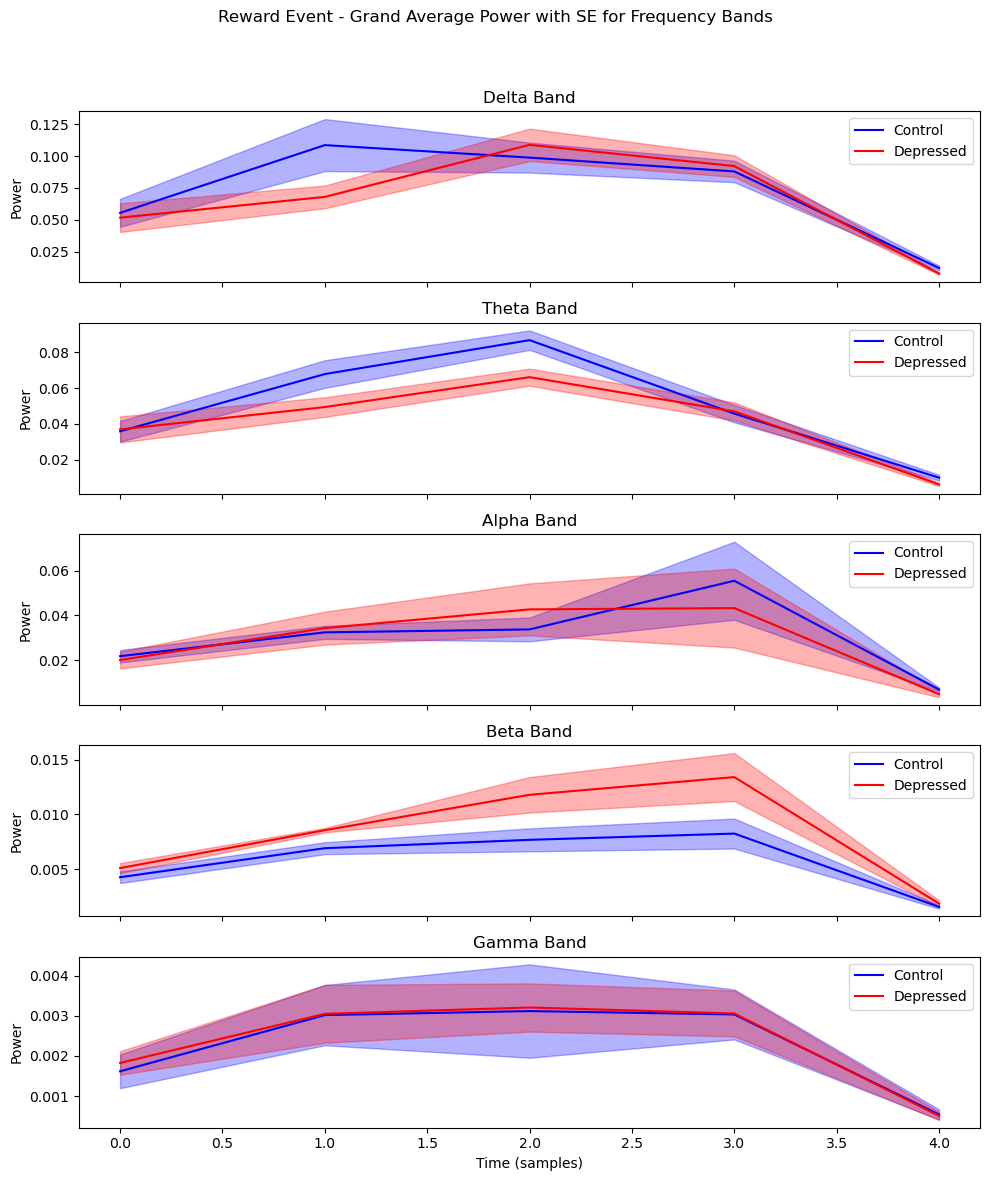

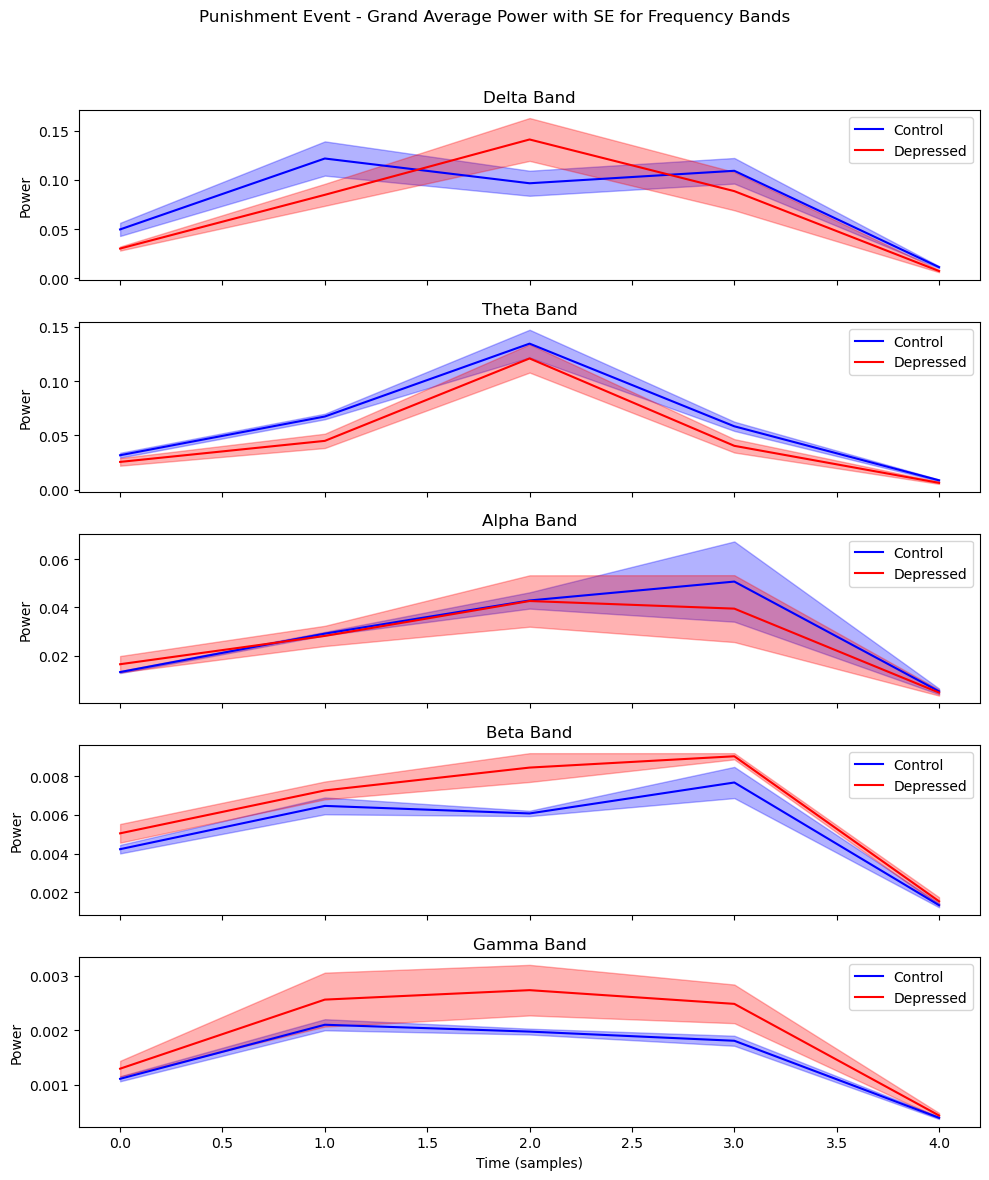

In [16]:
def plot_grand_avg_with_se(grand_avg, se, condition_name):
    fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f"{condition_name} Event - Grand Average Power with SE for Frequency Bands")

    for i, (band, _) in enumerate(frequency_bands.items()):
        ax = axes[i]
        ax.set_title(f"{band.capitalize()} Band")
        
        ax.plot(grand_avg["Control"][i, :], label="Control", color="blue")
        ax.fill_between(range(grand_avg["Control"].shape[1]),
                        grand_avg["Control"][i, :] - se["Control"][i, :],
                        grand_avg["Control"][i, :] + se["Control"][i, :],
                        color="blue", alpha=0.3)

        ax.plot(grand_avg["Depressed"][i, :], label="Depressed", color="red")
        ax.fill_between(range(grand_avg["Depressed"].shape[1]),
                        grand_avg["Depressed"][i, :] - se["Depressed"][i, :],
                        grand_avg["Depressed"][i, :] + se["Depressed"][i, :],
                        color="red", alpha=0.3)

        ax.set_ylabel("Power")
        ax.legend(loc="upper right")

    axes[-1].set_xlabel("Time (samples)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_grand_avg_with_se(reward_grand_avg, reward_se, "Reward")
plot_grand_avg_with_se(punishment_grand_avg, punishment_se, "Punishment")